In [1]:
import numpy as np
from pandas import DataFrame as df

C:\Users\ChristiaanMeijer\anaconda3\envs\robot\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ChristiaanMeijer\anaconda3\envs\robot\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\ChristiaanMeijer\anaconda3\envs\robot\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Load the 3 dataset splits

In [2]:
from utils import generate_dataset_from_images

val_set, _ = generate_dataset_from_images('validation')
test_set, _ = generate_dataset_from_images('test')
train_set, class_list = generate_dataset_from_images('train')
datasets = {'validation':val_set, 'test':test_set,'train':train_set}

Loaded validation set with 750 instances.
Loaded test set with 1248 instances.
Loaded train set with 2999 instances.


### Print class counts for each split

In [3]:
df({k:v['y'].value_counts() for k,v  in datasets.items()})

,validation,test,train
None of the above,267,443,1067
Acting or Performing machine,168,281,674
Collaborative or Interactive AI,109,182,438
Thinking machine,94,156,373
Complex AI,87,145,347
Mysterious AI,13,21,50
Superior human,8,14,34
Learning or recognition machine,4,6,16


Some of these counts are horrible. The number of examples in 'Learning or recognition machine', 'Superior human' and 'Mysterious AI' are really too small. Also, the 'None of the above' class is very large, although that's not really a problem.

### Create a prompt for each class

In [4]:
acting = "Machine,robot or product, performing an act or task"
collab = "AI interacting with humans, AI performs a task that supports humans."
complx = "AI visualized as complex data, complex interactions/nodes/networks"
learning = "AI scanning or recognizing data points in traffic, shops, or faces"
mysterious = "AI working “magically” or in a mysterious way."
other = "car horse cat house bicycle cook shoe plane spider animal weapon boat tree"
superior = "AI depicted as technology that is created and/or controlled by humans."
thinking = "AI visualized as a brain, face, eye, android storing large amounts of data"

prompts = [acting, collab, complx, learning, mysterious, other, superior, thinking]
classes_by_prompt = {k:v for k, v in zip(prompts, class_list)}
classes_by_prompt

{'Machine,robot or product, performing an act or task': 'Acting or Performing machine',
 'AI interacting with humans, AI performs a task that supports humans.': 'Collaborative or Interactive AI',
 'AI visualized as complex data, complex interactions/nodes/networks': 'Complex AI',
 'AI scanning or recognizing data points in traffic, shops, or faces': 'Learning or recognition machine',
 'AI working “magically” or in a mysterious way.': 'Mysterious AI',
 'car horse cat house bicycle cook shoe plane spider animal weapon boat tree': 'None of the above',
 'AI depicted as technology that is created and/or controlled by humans.': 'Superior human',
 'AI visualized as a brain, face, eye, android storing large amounts of data': 'Thinking machine'}

### Create classifier using clip and the prompts

In [5]:
from PIL import Image
import clip
import torch
import numpy as np

def predict_image_with_clip(image_path):
    #See first example at https://github.com/openai/CLIP#usage
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)

    img = Image.open(image_path)
    image = preprocess(img).unsqueeze(0).to(device)
    text = clip.tokenize(prompts).to(device)

    with torch.no_grad():
        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    prediction = np.argmax(probs)
    return prediction


    # for prob, label in sorted(zip(probs[0], labels), key=lambda x : x[0], reverse=True):
    #     print(f'{prob:.2f} {label}')

predict_image_with_clip(val_set['paths'][1])

0

In [9]:
from tqdm import tqdm

predicted = [class_list[predict_image_with_clip(p)] for p in tqdm(test_set['paths'][::])]
trues = test_set['y'][::].values

100%|██████████| 1248/1248 [1:22:11<00:00,  3.95s/it]


In [10]:
from pandas import DataFrame as df
print(df(predicted).value_counts())
print(df(trues).value_counts())

Acting or Performing machine       353
Superior human                     275
Collaborative or Interactive AI    214
Learning or recognition machine    155
Mysterious AI                       97
Thinking machine                    97
Complex AI                          43
None of the above                   14
dtype: int64
None of the above                  443
Acting or Performing machine       281
Collaborative or Interactive AI    182
Thinking machine                   156
Complex AI                         145
Mysterious AI                       21
Superior human                      14
Learning or recognition machine      6
dtype: int64


### Performance metrics for clip based classifier

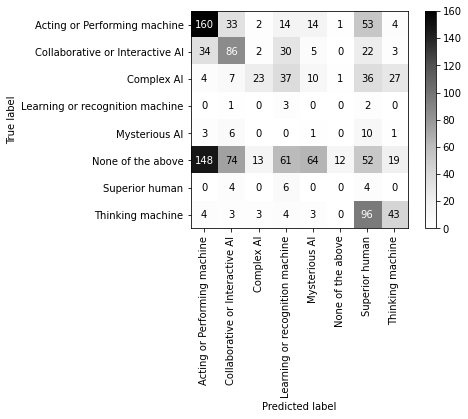

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion = confusion_matrix(trues, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion,                               display_labels=class_list)
_ = disp.plot(cmap='Greys', xticks_rotation='vertical')


In [12]:
from utils import display_performance_metrics

display_performance_metrics(trues, predicted, class_list)


,recall,precision,f1
Acting or Performing machine,0.57,0.45,0.50
Collaborative or Interactive AI,0.47,0.40,0.43
Complex AI,0.16,0.53,0.24
Learning or recognition machine,0.50,0.02,0.04
Mysterious AI,0.05,0.01,0.02
None of the above,0.03,0.86,0.05
Superior human,0.29,0.01,0.03
Thinking machine,0.28,0.44,0.34


,score
accuracy,0.27
krippendorff alpha,0.13
